# Definitions

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import os, os.path
import win32com.client
import xlwings as xw
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Display entire Scenario string in notebook
pd.options.display.max_colwidth = 4000

# Functions

In [306]:
def read_from_new_DSS(DSS_file_path, output_tab, model_order):
    
    # Read calc data from Excel
    columns_from_excel = 'F,G,I,T,V,X,Z,U,KU,LE,MK'
    column_headers = ['scenarios', 'cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'DFL_delta', 'BC_delta', 'spend_delta', 'lift_delta', 'elasticity']
    df = pd.read_excel(DSS_file_path, sheet_name='Calc', names=column_headers, skiprows=500*(model_order)-1, nrows=500, usecols=columns_from_excel)
    
    # Read chosen scenarios from output_tab and append to df
    chosen_scenarios = pd.read_excel(DSS_file_path, names=['target_scenarios'], sheet_name=output_tab, usecols='C', skiprows=34, nrows=46)
    chosen_scenarios = chosen_scenarios.iloc[::2]
    chosen_scenarios = chosen_scenarios.dropna()
    chosen_scenarios = chosen_scenarios['target_scenarios'].astype('int')
    df['target_scenarios'] = 0
    for index, row in chosen_scenarios.iteritems():
        df['target_scenarios'].iloc[row-1] = 1
        
    # Remove (#) and spaces at beginning and end of Scenario
    df['scenarios'] = df['scenarios'].str.replace('\\(.\\)','', regex=True).str.lstrip().str.rstrip()

    # Create delta_spend columns in data
    # Note: need to add user input baseline (currently controlled in if index % 500 == x)
    delta_columns = ['cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'BC_delta', 'DFL_delta', 'spend_delta', 'lift_delta']
    for x in delta_columns:
        baseline = 0
        df_delta = []
        if x == 'lift_delta':
            for index, row in df.iterrows():
                if index % 500 == 11:
                    baseline = row[x]
                try:
                    delta = row[x]/baseline - 1
                    df_delta.append(delta)
                except:
                    delta = row[x] - baseline
                    df_delta.append(delta)
        else:
            for index, row in df.iterrows():
                if index % 500 == 11:
                    baseline = row[x]
                delta = row[x] - baseline
                df_delta.append(delta)
        df[x] = df_delta

    # Create no_of_moves column
    no_of_moves = 0
    df_no_of_moves = []

    for index, row in df.iterrows():
        no_of_moves = str(row['scenarios']).count('\n') + 1
        df_no_of_moves.append(no_of_moves)

    df['no_of_moves'] = df_no_of_moves

    # Find efficient frontier (only model #1 so far)
    df_length = df.shape[0]
    eff_front = pd.DataFrame()

    for i in range(0,df_length,df_length):
        for k in range(13,df_length):
            current_spend = df['spend_delta'][k + i]
            current_lift = df['lift_delta'][k + i]
            for j in range(13,df_length):
                new_spend = df['spend_delta'][j + i]
                new_lift = df['lift_delta'][j + i]
                if (new_spend < current_spend) & (new_lift > current_lift):
                    break
                elif (np.isnan(df['spend_delta'][j + i])) & (j == df_length-1):
                    if np.isnan(df['spend_delta'][k + i]):
                        continue
                    else:
                        eff_front = eff_front.append(df.iloc[[k+i]])

    # Drop N/As & duplicate scenarios
    eff_front = eff_front.dropna()
    eff_front = eff_front.drop_duplicates(subset=['elasticity','lift_delta','spend_delta'], keep='first')

    return eff_front

In [307]:
def read_from_old_DSS(DSS_file_path, output_tab, model_order):
    
    # Read data from Excel
    columns_from_excel = 'D,E,Q,Y,F,G,H,Z,JD,JM,KU'
    column_headers = ['scenarios', 'cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'DFL_delta', 'BC_delta', 'spend_delta', 'lift_delta', 'elasticity']
    df = pd.read_excel(DSS_file_path, sheet_name='DSS_Calc', names=column_headers, skiprows=100*(model_order)-1, nrows=100, usecols=columns_from_excel)
    
    # Read chosen scenarios from output_tab and append to df
    chosen_scenarios = pd.read_excel(DSS_file_path, names=['target_scenarios'], sheet_name=output_tab, usecols='C', skiprows=32, nrows=46)
    chosen_scenarios = chosen_scenarios.iloc[::2]
    chosen_scenarios = chosen_scenarios[~chosen_scenarios.isin(['x'])]
    chosen_scenarios = chosen_scenarios.dropna()
    chosen_scenarios = chosen_scenarios['target_scenarios'].astype('int')
    df['target_scenarios'] = 0
    for index, row in chosen_scenarios.iteritems():
        df['target_scenarios'].iloc[row-1] = 1
        
    # Remove (#) and spaces at beginning and end of Scenario
    df['scenarios'] = df['scenarios'].str.replace('\\(.\\)','', regex=True).str.lstrip().str.rstrip()

    # Create delta_spend columns in data
    # Note: need to add user input baseline (currently controlled in if index % 200 == x)
    delta_columns = ['cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'BC_delta', 'DFL_delta', 'spend_delta', 'lift_delta']
    for x in delta_columns:
        baseline = 0
        df_delta = []
        if x == 'lift_delta':
            for index, row in df.iterrows():
                if index % (100) == 1:
                    baseline = row[x]
                try:
                    delta = row[x]/baseline - 1
                    df_delta.append(delta)
                except:
                    delta = row[x] - baseline
                    df_delta.append(delta)
        else:
            for index, row in df.iterrows():
                if index % (100) == 1:
                    baseline = row[x]
                delta = row[x] - baseline
                df_delta.append(delta)
        df[x] = df_delta

    # Create no_of_moves column
    no_of_moves = 0
    df_no_of_moves = []

    for index, row in df.iterrows():
        no_of_moves = str(row['scenarios']).count(',')
        df_no_of_moves.append(no_of_moves)

    df['no_of_moves'] = df_no_of_moves

    # Find efficient frontier (only model #1 so far)
    df_length = df.shape[0]
    eff_front = pd.DataFrame()

    for i in range(0,df_length,df_length):
        for k in range(8,df_length):
            current_spend = df['spend_delta'][k + i]
            current_lift = df['lift_delta'][k + i]
            for j in range(8,df_length):
                new_spend = df['spend_delta'][j + i]
                new_lift = df['lift_delta'][j + i]
                if (new_spend < current_spend) & (new_lift > current_lift):
                    break
                elif (np.isnan(df['spend_delta'][j + i])) & (j == df_length-1):
                    if np.isnan(df['spend_delta'][k + i]):
                        continue
                    else:
                        eff_front = eff_front.append(df.iloc[[k+i]])

    # Drop N/As & duplicate scenarios
    eff_front = eff_front.dropna()
    eff_front = eff_front.drop_duplicates(subset=['elasticity','lift_delta','spend_delta'], keep='first')

    return eff_front

In [287]:
def DSS_extract_models_and_output_tabs(DSS_file_path):
    file = openpyxl.load_workbook(DSS_file_path)
    
    output_tabs = []
    for sheet in file.sheetnames:
        for row in range(1,10):
            for col in range(26,100):
                if file[sheet].cell(row=row, column=col).value == 'PPT Slide Width:':
                    output_tabs.append(sheet)
                    
    model_list = []
    for i in range(0,9):
        model = file['Input'].cell(row=3, column=7 + i*6).value
        model_list.append(model)
    
    return model_list, output_tabs

# Kia Runs

##### control

In [6]:
DSS_file_path = r'C:\Users\bryant.vu\Documents\Python_Scripts\18.05.07-DSS-Template-v3.3 - MY20 Sportage 20 01 03.xlsm'
tab_name = 'R2'
model_order_in_workbook = 5
spend_min = -300
spend_max = 300

In [7]:
scenarios = pd.DataFrame()
df = read_from_old_DSS(DSS_file_path, tab_name, model_order_in_workbook)
scenarios = df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\bryant.vu\\Documents\\Python_Scripts\\18.05.07-DSS-Template-v3.3 - MY20 Sportage 20 01 03.xlsm'

###### Remove client-specific unwanted scenarios 

In [334]:
# Remove single lever moves (add user option in later)
scenarios['lift/spend'] = scenarios['lift_delta'] / scenarios['spend_delta']
scenarios = scenarios[scenarios['no_of_moves'] > 1].sort_values('spend_delta')

# Remove APR moves with std
reg_ex = 'std'
reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
scenarios = scenarios[~reg_ex_filter]


###### Rank

In [335]:
# Create scoring system ranks

# Elasticity as % of max elasticity
scenarios['elasticity_score'] = scenarios['elasticity']/scenarios['elasticity'].max()/10*1.5

# No. of moves as A B C D F grading scale
no_of_moves_dict = {
    1: .95,
    2: .90,
    3: .85,
    4: .80,
    5: .75,
    6: .70
}
scenarios['no_of_moves_score'] = scenarios['no_of_moves'].map(no_of_moves_dict)

# Spend delta as % of max delta divided by 10 
scenarios['spend_delta_score'] = -abs(scenarios['spend_delta'])/scenarios['spend_delta'].max()

# Total score
scenarios['total_score'] = scenarios['elasticity_score'] + scenarios['no_of_moves_score']
scenarios.sort_values('total_score', ascending=False, inplace=True)

In [336]:
scenarios = scenarios[scenarios['spend_delta'] > spend_min]
scenarios = scenarios[scenarios['spend_delta'] < spend_max]

In [337]:
scenarios

,scenarios,cash_delta,finance_delta,lease_delta,DC_delta,DFC_delta,DFL_delta,BC_delta,spend_delta,lift_delta,elasticity,target_scenarios,no_of_moves,lift/spend,elasticity_score,no_of_moves_score,spend_delta_score,total_score
51,"0/0/0/0.9, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,111.873703,0.018815,4.611764,0,2,0.000168,0.148368,0.90,-0.119682,1.048368
47,"500 CC, -360 Lease,",500.0,0.0,0.0,0.0,0.0,-360.0,0.0,76.827706,0.014620,4.611391,0,2,0.000190,0.148356,0.90,-0.082190,1.048356
48,"750 CC, -360 Lease,",750.0,0.0,0.0,0.0,0.0,-360.0,0.0,197.109648,0.028906,4.611356,0,2,0.000147,0.148355,0.90,-0.210867,1.048355
50,"0/0/0/1.9, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,44.041838,0.010429,4.607826,0,2,0.000237,0.148241,0.90,-0.047116,1.048241
46,"250 CC, -360 Lease,",250.0,0.0,0.0,0.0,0.0,-360.0,0.0,-32.014283,0.001139,4.604602,1,2,-0.000036,0.148137,0.90,-0.034249,1.048137
88,"500 CC, -180 Lease,",500.0,0.0,0.0,0.0,0.0,-180.0,0.0,127.047651,0.019915,4.603562,0,2,0.000157,0.148104,0.90,-0.135915,1.048104
53,"0/0/0/0, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,224.545306,0.031204,4.600400,0,2,0.000139,0.148002,0.90,-0.240217,1.048002
52,"0/0/0/0, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,224.545306,0.031204,4.600399,0,2,0.000139,0.148002,0.90,-0.240217,1.048002
89,"0/0/0/1.9, -180 Lease,",0.0,0.0,0.0,0.0,0.0,-180.0,0.0,101.533714,0.016011,4.593173,0,2,0.000158,0.147770,0.90,-0.108620,1.047770
87,"250 CC, -180 Lease,",250.0,0.0,0.0,0.0,0.0,-180.0,0.0,23.717041,0.006611,4.590848,1,2,0.000279,0.147695,0.90,-0.025372,1.047695


##### plot

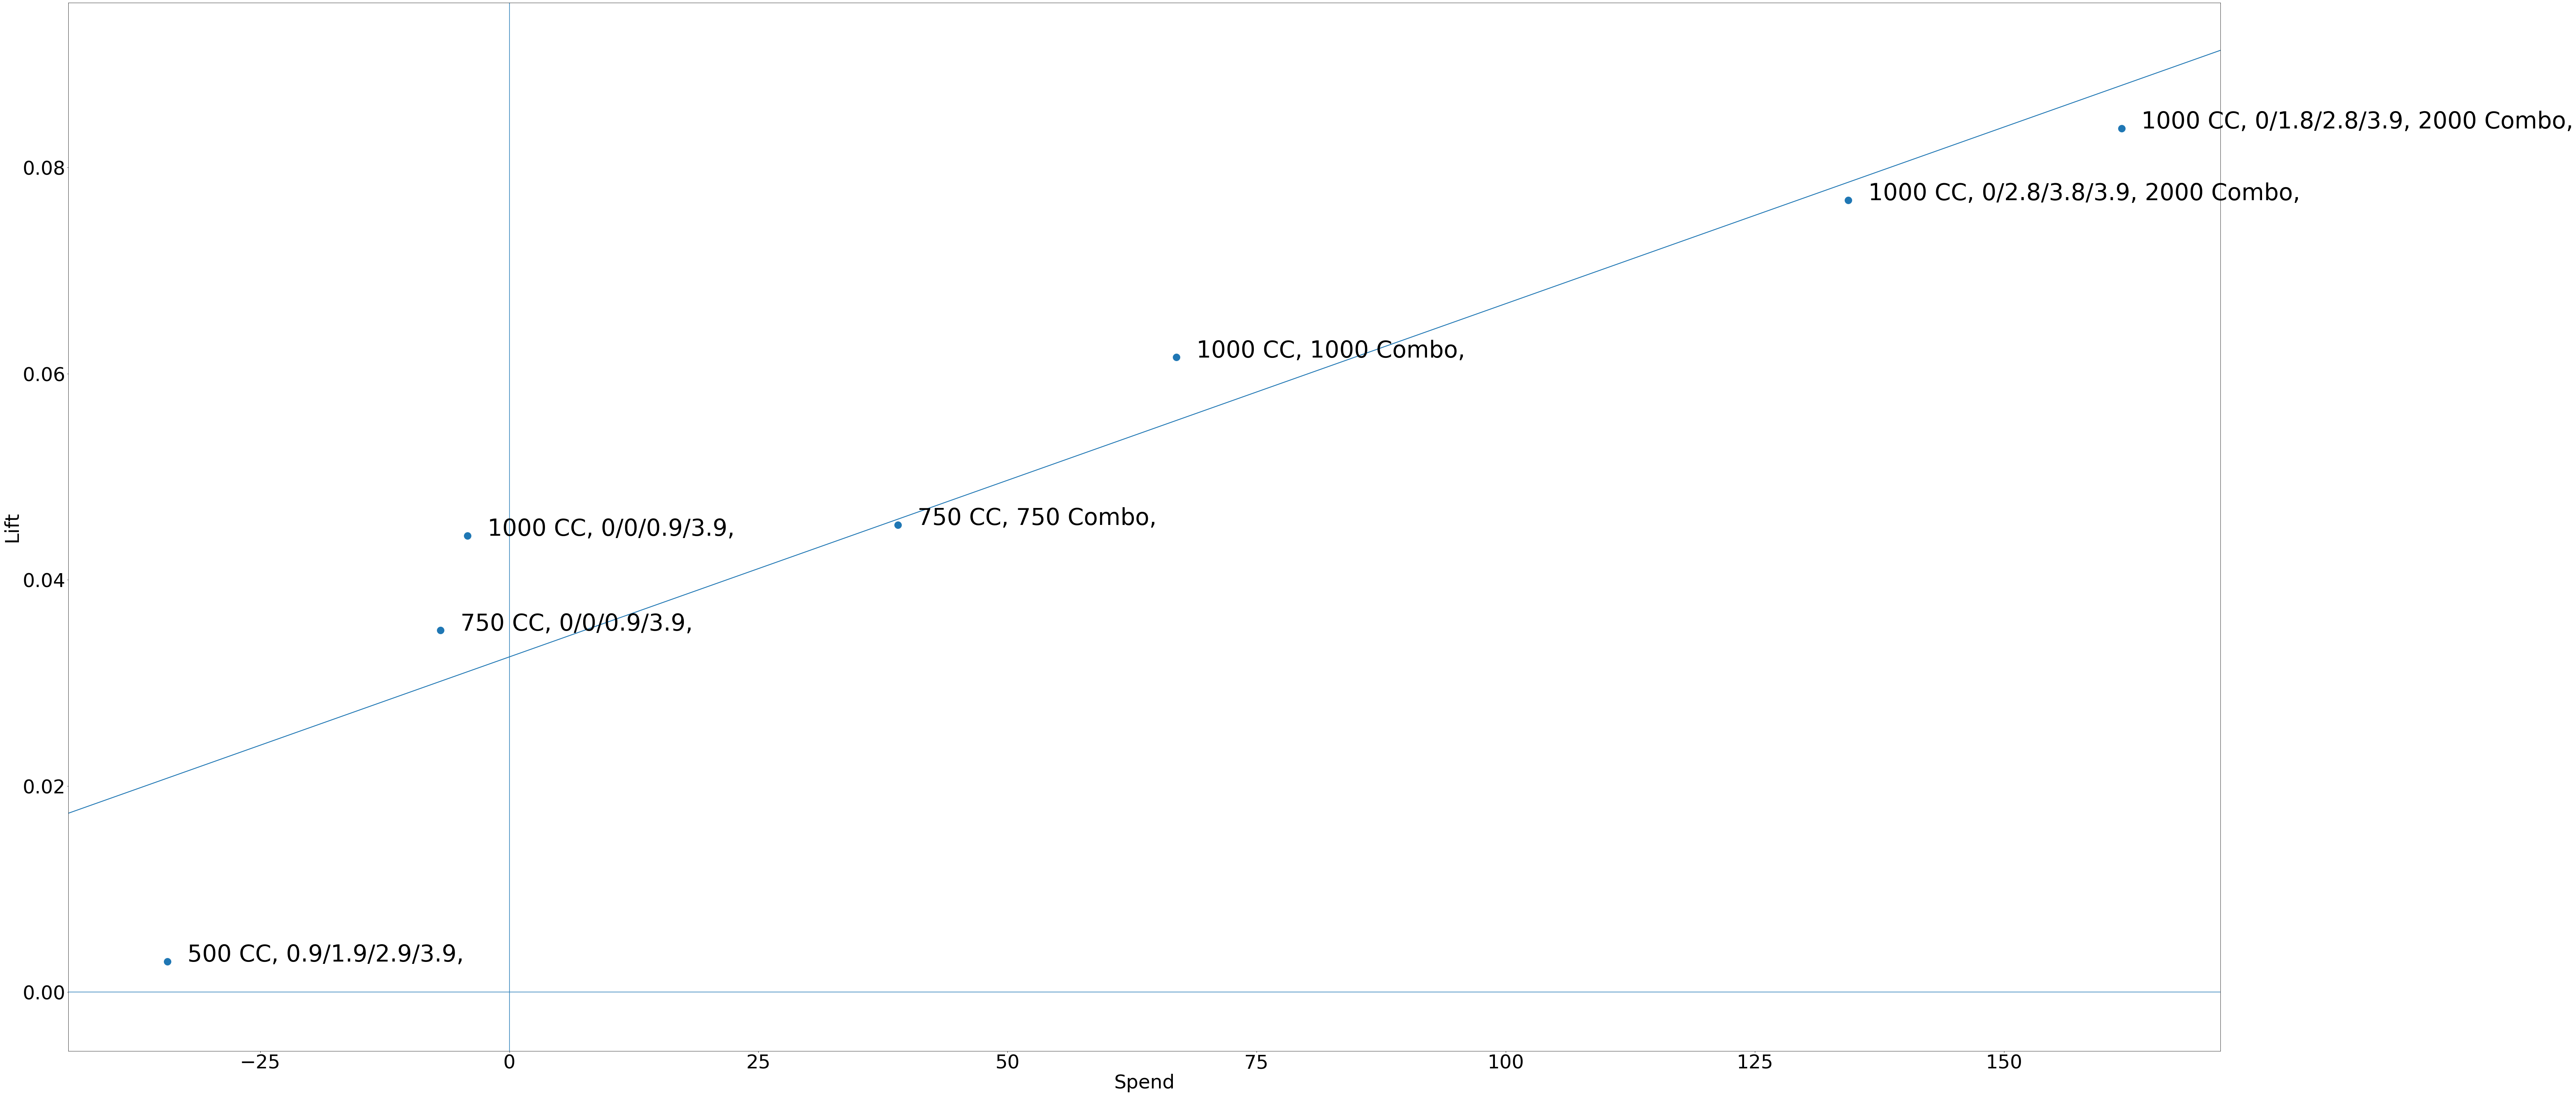

In [181]:
# Plot remaining scenarios w best fit line
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], s=400)
p2 = sns.regplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for row in range(0, scenarios.shape[0]):
    p1.text(scenarios['spend_delta'].iloc[row]+2, scenarios['lift_delta'].iloc[row], scenarios['scenarios'].iloc[row], size=60)
      
plt.show()

# Mitsu Run

In [313]:
DSS_file_path = r'C:\Users\bryant.vu\Documents\Chooser_DSS_Files\dss_copy\2019.12.11 - DSS - v4.7.2 - 7 block - Mitsu MY20 v5.xlsm'

In [314]:
model_list, output_tabs = DSS_extract_models_and_output_tabs(DSS_file_path)
tab_name = output_tabs[model_no-1]

In [315]:
model_no = 1
spend_min = -100
spend_max = 500

In [316]:
scenarios = pd.DataFrame()
scenarios = read_from_new_DSS(DSS_file_path, tab_name, model_no)

###### Remove client-specific unwanted scenarios 

In [317]:
# Remove single lever moves (add user option in later)
scenarios['lift/spend'] = scenarios['lift_delta'] / scenarios['spend_delta']
scenarios = scenarios[scenarios['no_of_moves'] > 1].sort_values('spend_delta')

# Remove APR moves with std
reg_ex = 'std'
reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
scenarios = scenarios[~reg_ex_filter]

# Remove +CC and -APR moves
##reg_ex_cash = '*APR'
#reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
CC_APR_nonzero_filter = (scenarios['cash_delta'] != 0) & (scenarios['finance_delta'] != 0)
scenarios['cash_finance_sum'] = round(scenarios['cash_delta']/50.0)*50 + round(scenarios['finance_delta']/50.0)*50
cash_finance_sum_filter = scenarios['cash_finance_sum'] == 0.0

scenarios = scenarios[~(CC_APR_nonzero_filter & cash_finance_sum_filter)]

###### Rank

In [318]:
# Create scoring system ranks

# Elasticity as % of max elasticity
scenarios['elasticity_score'] = scenarios['elasticity']/scenarios['elasticity'].max()/10*1.5

# No. of moves as A B C D F grading scale
no_of_moves_dict = {
    1: .95,
    2: .90,
    3: .85,
    4: .80,
    5: .75,
    6: .70
}
scenarios['no_of_moves_score'] = scenarios['no_of_moves'].map(no_of_moves_dict)

# Spend delta as % of max delta divided by 10 
scenarios['spend_delta_score'] = -abs(scenarios['spend_delta'])/scenarios['spend_delta'].max()

# Total score
scenarios['total_score'] = scenarios['elasticity_score'] + scenarios['no_of_moves_score']
scenarios.sort_values('total_score', ascending=False, inplace=True)

In [319]:
scenarios = scenarios[scenarios['spend_delta'] > spend_min]
scenarios = scenarios[scenarios['spend_delta'] < spend_max]

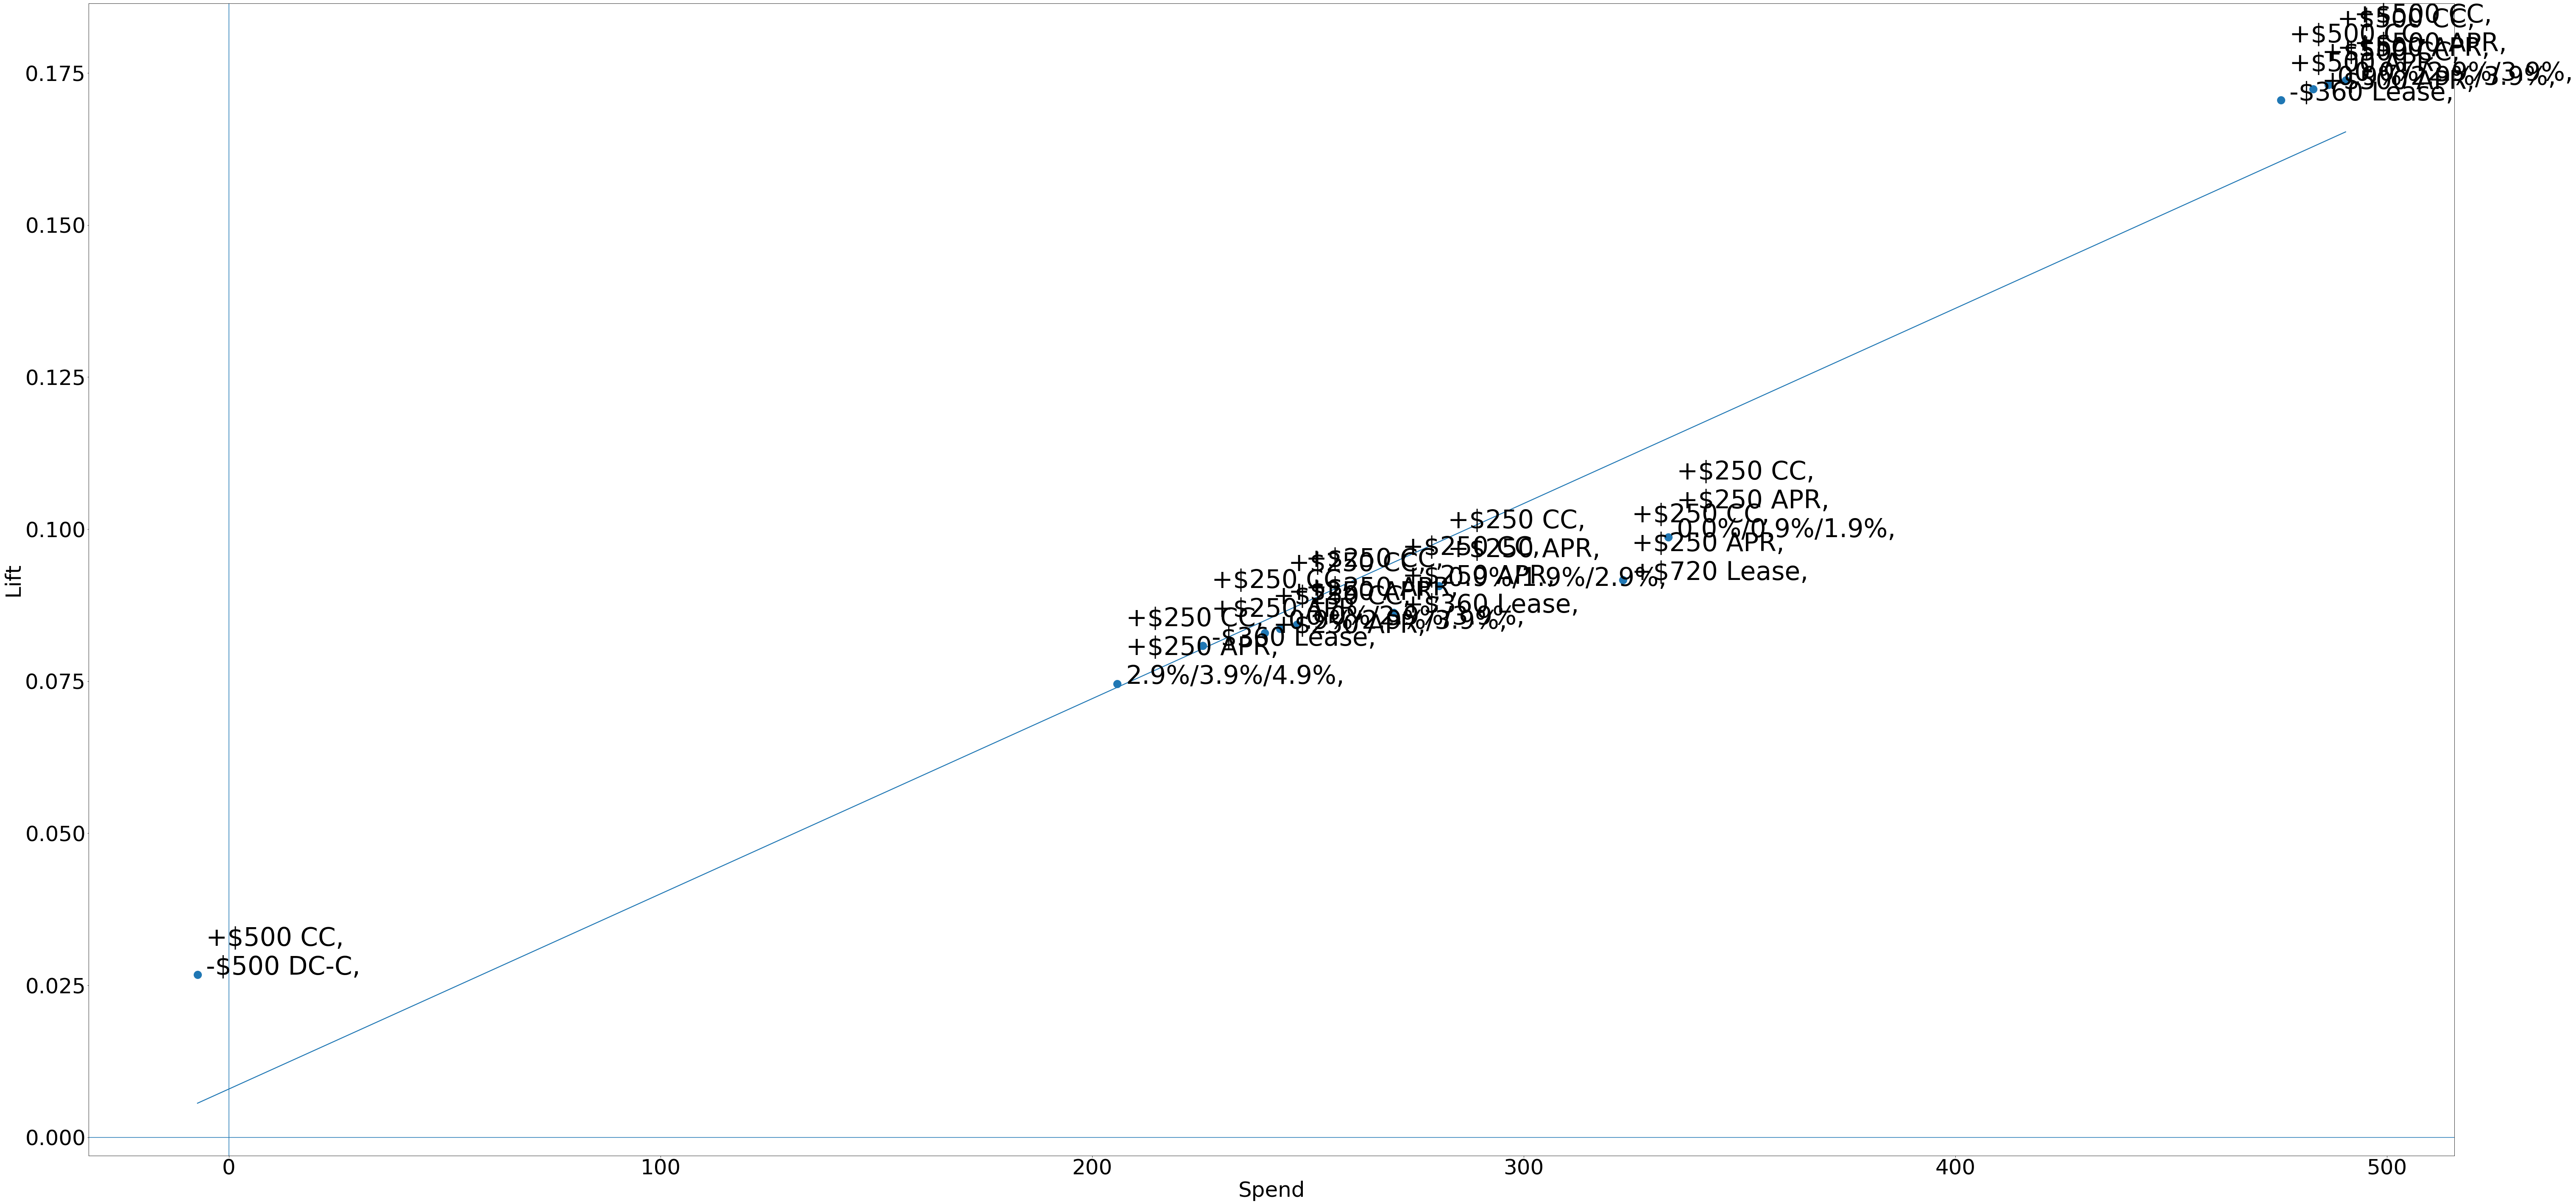

In [320]:
# Plot remaining scenarios w best fit line
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], s=400)
p2 = sns.regplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for row in range(0, scenarios.shape[0]):
    p1.text(scenarios['spend_delta'].iloc[row]+2, scenarios['lift_delta'].iloc[row], scenarios['scenarios'].iloc[row], size=60)
      
plt.show()

In [321]:
scenarios_row = list(scenarios.index.values)

In [322]:
scenarios

,scenarios,cash_delta,finance_delta,lease_delta,DC_delta,DFC_delta,DFL_delta,BC_delta,spend_delta,lift_delta,elasticity,target_scenarios,no_of_moves,lift/spend,cash_finance_sum,elasticity_score,no_of_moves_score,spend_delta_score,total_score
44,"+$500 CC, \n+$500 APR,",500.0,500.0,0.0,0.0,0.0,0.0,0.0,482.913835,0.172338,4.786383,0,2,0.000357,1000.0,0.121414,0.90,-0.452144,1.021414
43,"+$250 CC, \n+$250 APR,",250.0,250.0,0.0,0.0,0.0,0.0,0.0,239.959149,0.082946,4.636137,1,2,0.000346,500.0,0.117602,0.90,-0.224670,1.017602
67,"+$250 CC, \n+$250 APR, \n2.9%/3.9%/4.9%,",250.0,250.0,0.0,0.0,0.0,0.0,0.0,205.850991,0.074548,4.857120,1,3,0.000362,500.0,0.123208,0.85,-0.192735,0.973208
92,"+$500 CC, \n+$500 APR, \n-$360 Lease,",500.0,500.0,-360.0,0.0,0.0,0.0,0.0,475.384616,0.170509,4.810603,0,3,0.000359,1000.0,0.122028,0.85,-0.445095,0.972028
91,"+$250 CC, \n+$250 APR, \n-$360 Lease,",250.0,250.0,-360.0,0.0,0.0,0.0,0.0,225.676463,0.080835,4.804094,0,3,0.000358,500.0,0.121863,0.85,-0.211297,0.971863
134,"+$500 CC, \n+$500 APR, \n0.9%/2.9%/3.9%,",500.0,500.0,0.0,0.0,0.0,0.0,0.0,486.438995,0.173059,4.771591,0,3,0.000356,1000.0,0.121038,0.85,-0.455445,0.971038
138,"+$500 CC, \n+$500 APR, \n0.0%/2.9%/3.9%,",500.0,500.0,0.0,0.0,0.0,0.0,0.0,490.400123,0.173782,4.752810,0,3,0.000354,1000.0,0.120562,0.85,-0.459153,0.970562
133,"+$250 CC, \n+$250 APR, \n0.9%/2.9%/3.9%,",250.0,250.0,0.0,0.0,0.0,0.0,0.0,243.498709,0.083632,4.606531,0,3,0.000343,500.0,0.116851,0.85,-0.227984,0.966851
137,"+$250 CC, \n+$250 APR, \n0.0%/2.9%/3.9%,",250.0,250.0,0.0,0.0,0.0,0.0,0.0,247.482948,0.084322,4.569759,0,3,0.000341,500.0,0.115919,0.85,-0.231714,0.965919
59,"+$250 CC, \n+$250 APR, \n0.9%/1.9%/2.9%,",250.0,250.0,0.0,0.0,0.0,0.0,0.0,280.393642,0.090654,4.336285,0,3,0.000323,500.0,0.109996,0.85,-0.262528,0.959996


In [323]:
def write_to_output_tab(DSS_file_path, tab_name, scenarios_row):
    wb = xw.Book(DSS_file_path)
    ws = wb.sheets[tab_name]
    
    for index, value in enumerate(scenarios_row):
        row_index = int(value) + 1
        ws.range(36+2*i, 8).value = value
        
    wb.save('new_wb.xlsm')

In [213]:
write_to_output_tab(DSS_file_path, tab_name, scenarios_row)